In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
orders = pd.read_csv('/content/drive/MyDrive/E-Commerce Public Dataset/orders_dataset.csv')
reviews = pd.read_csv('/content/drive/MyDrive/E-Commerce Public Dataset/order_reviews_dataset.csv')
payments = pd.read_csv('/content/drive/MyDrive/E-Commerce Public Dataset/order_payments_dataset.csv')
items = pd.read_csv('/content/drive/MyDrive/E-Commerce Public Dataset/order_items_dataset.csv')

In [4]:
# Convert timestamps to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [5]:
# Merge datasets
data = pd.merge(orders, reviews, on='order_id')
data = pd.merge(data, payments, on='order_id')
data = pd.merge(data, items, on='order_id')

In [6]:
# Calculating delivery time in days
data['delivery_time'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
data['estimated_delivery_time'] = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days
data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

In [7]:
# Handling missing values
data['delivery_time'].fillna(data['delivery_time'].mean(), inplace=True)
data['estimated_delivery_time'].fillna(data['estimated_delivery_time'].mean(), inplace=True)
data['delivery_delay'].fillna(data['delivery_delay'].mean(), inplace=True)

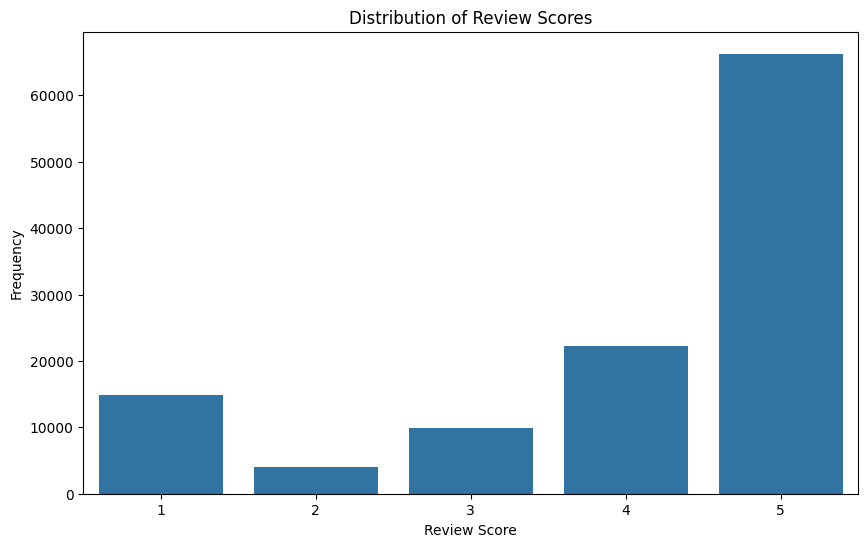

In [8]:
# Visualization of review scores
plt.figure(figsize=(10, 6))
sns.countplot(x='review_score', data=data)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

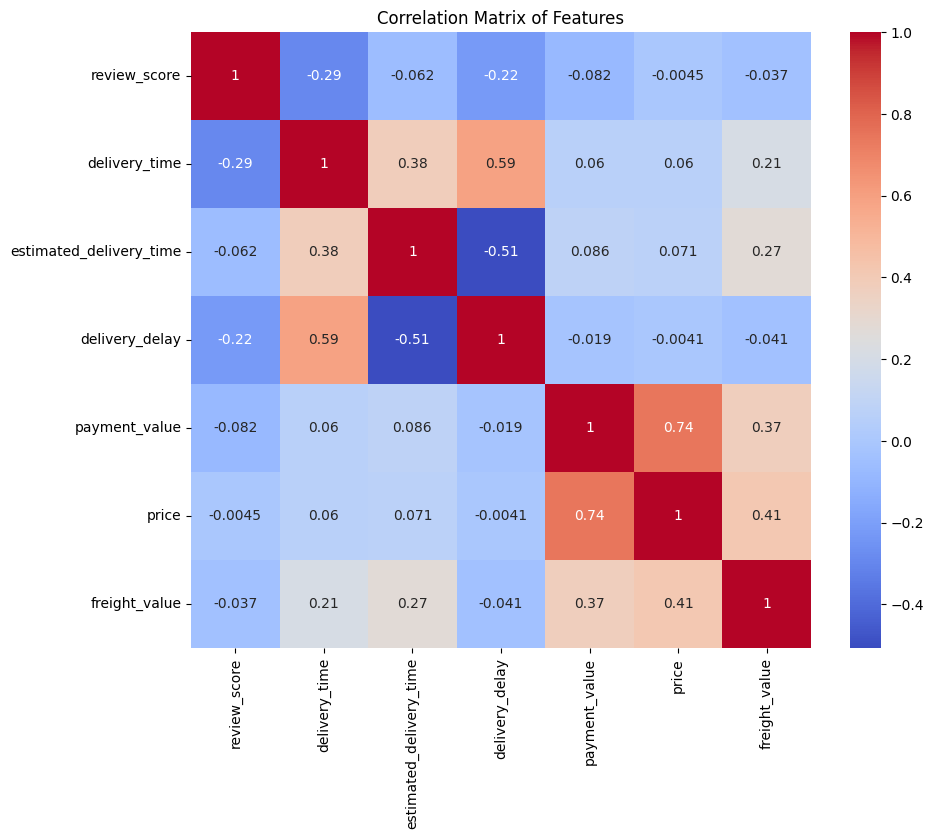

In [9]:
# Correlation heatmap
correlation_features = data[['review_score', 'delivery_time', 'estimated_delivery_time', 'delivery_delay', 'payment_value', 'price', 'freight_value']]
corr_matrix = correlation_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

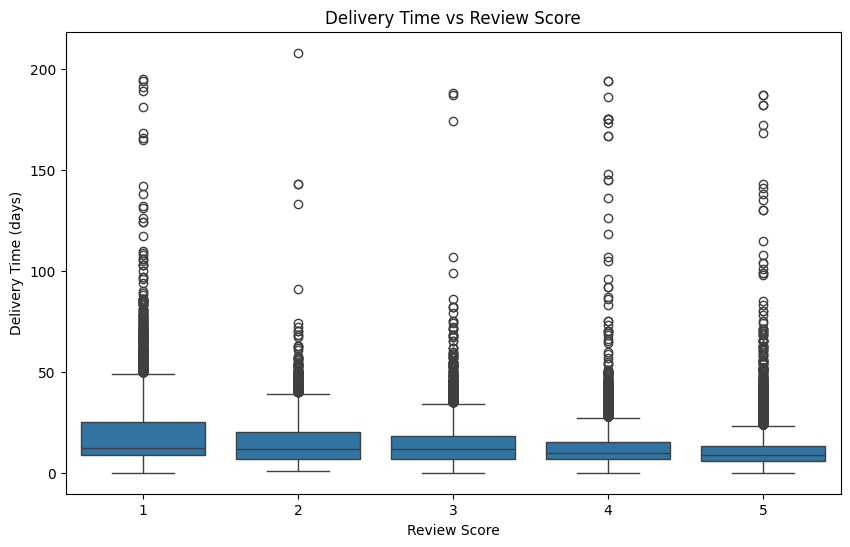

In [10]:
# Delivery time vs Review Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=data)
plt.title('Delivery Time vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.show()

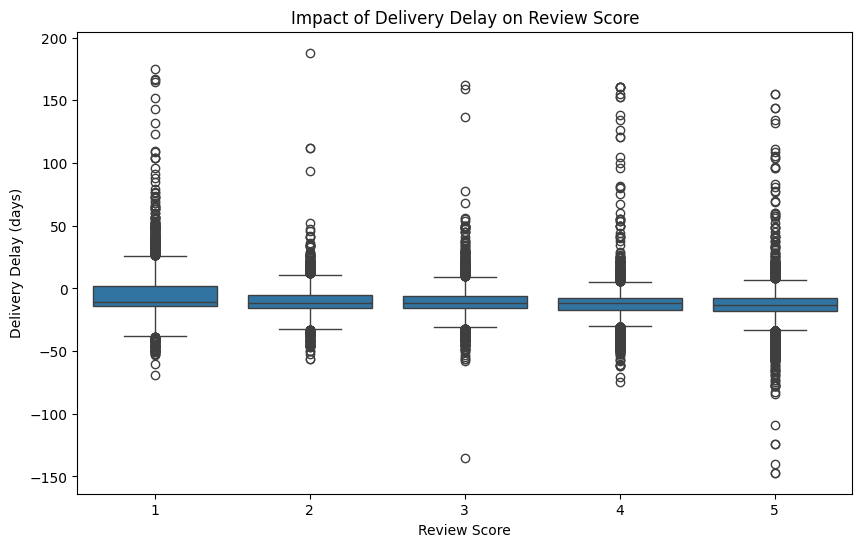

In [11]:
# Delivery delay impact
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_delay', data=data)
plt.title('Impact of Delivery Delay on Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Delay (days)')
plt.show()

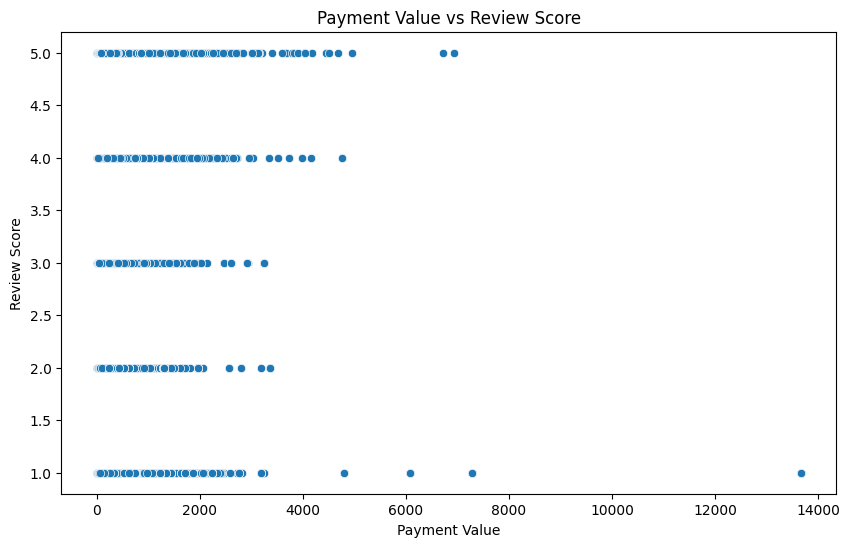

In [12]:
# Payment value vs Review Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='payment_value', y='review_score', data=data)
plt.title('Payment Value vs Review Score')
plt.xlabel('Payment Value')
plt.ylabel('Review Score')
plt.show()

In [13]:
# Convert timestamps to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Merge datasets
data = pd.merge(orders, reviews, on='order_id')
data = pd.merge(data, payments, on='order_id')
data = pd.merge(data, items, on='order_id')

# Cleaning missing values
data['order_delivered_customer_date'].fillna(data['order_delivered_customer_date'].mode()[0], inplace=True)

# Calculating delivery time in days
data['delivery_time'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
data['estimated_delivery_time'] = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days
data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

# Categorize delivery efficiency
data['delivery_performance'] = np.where(data['delivery_delay'] <= 0, 'On Time or Early', 'Late')

# Aggregate payment information
data['total_payment'] = data.groupby('order_id')['payment_value'].transform('sum')

# Encoding categorical variables
data['payment_type_encoded'] = data['payment_type'].astype('category').cat.codes
data['delivery_performance_encoded'] = data['delivery_performance'].astype('category').cat.codes

# Customer experience score based on delivery and payment
data['customer_experience_score'] = data['delivery_time'] / data['total_payment']
data['customer_experience_score'] = data['customer_experience_score'].apply(lambda x: 1/(1 + np.exp(-x)))

# Binary classification for review score
data['review_score_class'] = data['review_score'].apply(lambda x: 1 if x > 3 else 0)

# Selecting features and target
features = [
    'delivery_time', 'estimated_delivery_time', 'delivery_delay', 'total_payment',
    'payment_type_encoded', 'delivery_performance_encoded', 'customer_experience_score'
]
X = data[features]
y = data['review_score_class']

# Display the new DataFrame with engineered features
print(data[features + ['review_score_class']].head())

   delivery_time  estimated_delivery_time  delivery_delay  total_payment  \
0              8                       15              -8          38.71   
1              8                       15              -8          38.71   
2              8                       15              -8          38.71   
3             13                       19              -6         141.46   
4              9                       26             -18         179.12   

   payment_type_encoded  delivery_performance_encoded  \
0                     1                             1   
1                     3                             1   
2                     3                             1   
3                     0                             1   
4                     1                             1   

   customer_experience_score  review_score_class  
0                   0.551483                   1  
1                   0.551483                   1  
2                   0.551483                   

In [14]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Making predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy of the model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy of the model: 0.8380209665047302
Confusion Matrix:
 [[ 3209  2653]
 [ 1148 16456]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.55      0.63      5862
           1       0.86      0.93      0.90     17604

    accuracy                           0.84     23466
   macro avg       0.80      0.74      0.76     23466
weighted avg       0.83      0.84      0.83     23466



In [15]:
from sklearn.feature_selection import SelectFromModel

# Building the RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]}) - {X.columns[indices[f]]}")

# Feature selection based on importances
sfm = SelectFromModel(rf, threshold=0.05)
sfm.fit(X_train_scaled, y_train)
X_important_train = sfm.transform(X_train_scaled)
X_important_test = sfm.transform(X_test_scaled)

# Rebuild model using selected features
rf_important = RandomForestClassifier(n_estimators=100, random_state=42)
rf_important.fit(X_important_train, y_train)
y_pred_important = rf_important.predict(X_important_test)

print("Accuracy on test data with important features: ", accuracy_score(y_test, y_pred_important))
print(confusion_matrix(y_test, y_pred_important))
print(classification_report(y_test, y_pred_important))

Feature ranking:
1. feature 6 (0.2942421672717173) - customer_experience_score
2. feature 3 (0.28883588710622055) - total_payment
3. feature 2 (0.1408127393982132) - delivery_delay
4. feature 0 (0.10918449847464766) - delivery_time
5. feature 1 (0.09763966959716193) - estimated_delivery_time
6. feature 5 (0.04218854157588749) - delivery_performance_encoded
7. feature 4 (0.02709649657615172) - payment_type_encoded
Accuracy on test data with important features:  0.8355919202250064
[[ 3268  2594]
 [ 1264 16340]]
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      5862
           1       0.86      0.93      0.89     17604

    accuracy                           0.84     23466
   macro avg       0.79      0.74      0.76     23466
weighted avg       0.83      0.84      0.83     23466



In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_important_train, y_train)
best_grid = grid_search.best_estimator_

y_pred_grid = best_grid.predict(X_important_test)
print("Best grid model accuracy: ", accuracy_score(y_test, y_pred_grid))
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best grid model accuracy:  0.847268388306486
[[ 3093  2769]
 [  815 16789]]
              precision    recall  f1-score   support

           0       0.79      0.53      0.63      5862
           1       0.86      0.95      0.90     17604

    accuracy                           0.85     23466
   macro avg       0.82      0.74      0.77     23466
weighted avg       0.84      0.85      0.84     23466



In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_important_train, y_train)

y_pred_gb = gb.predict(X_important_test)
print("Gradient Boosting model accuracy: ", accuracy_score(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting model accuracy:  0.8043978522117106
[[ 1577  4285]
 [  305 17299]]
              precision    recall  f1-score   support

           0       0.84      0.27      0.41      5862
           1       0.80      0.98      0.88     17604

    accuracy                           0.80     23466
   macro avg       0.82      0.63      0.65     23466
weighted avg       0.81      0.80      0.76     23466



In [19]:
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_grid.fit(X_train_scaled, y_train)
joblib.dump(best_grid, 'best_random_forest_model.joblib')
loaded_model = joblib.load('best_random_forest_model.joblib')

y_pred = loaded_model.predict(X_test_scaled)
print("Accuracy of the loaded model: ", accuracy_score(y_test, y_pred))

Accuracy of the loaded model:  0.8496122048921845


Conclusion:

*   Delivery: Delivery time and delays are key factors affecting customer satisfaction. Efforts to optimize delivery processes and logistics would be beneficial.

*   Service Quality: Although the transaction value does not significantly affect customer satisfaction, ensuring service quality remains crucial.

*   Strategic Analysis and Planning: Customer feedback analysis can inform product teams about potential improvements or developments needed in future products.

*   Product Development: Insights from the model can be used to tailor designs or features of new products to better meet customer preferences.

*   Customer Service Enhancement: The model can predict potential negative reviews allowing customer service teams to proactively address issues before they escalate.

*   Logistics Optimization: Identifying factors that affect customer satisfaction can guide improvements in logistics networks to expedite product deliveries.

